# Goals of this Notebook

- combine Story's and my analysis into one pipeline
- analyze and highlight differences between Story's and my analysis, make it easy to transition between the two with the change of a parameter

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

import sys
import os 
sys.path.append(os.path.abspath("../frbfuncs/"))
import cosmology as c 
import deprecated_cosmology as d

# Data

## variables to use:
- Story's dataset: dm, fluence, min_fluence, snr
- new CHIME dataset: dm_new, fluence_new, min_fluence_new, snr_new

In [4]:
import cfod
from cfod import catalog
CHIME = catalog.as_dataframe()

#### unpack FRB-cat1 data published by CHIME ####

snr, dm, low_ft_95, up_ft_95, flux, flux_err, fluence, fluence_err, = np.loadtxt(
    './data/chimefrbcat1.csv', skiprows=1, usecols=(17, 18, 21, 22, 31, 32, 34, 35), delimiter=',', unpack=True)

## note: low_ft_95, up_ft_95, flux, flux_err, fluence_err never used
##       tns, fluence_notes are never used
## only snr, dm, fluence are relevant

#### define minimmum fluence for each event #####

MIN_SNR = 12 # approx. threshold, according to CHIME's cat1 paper
min_fluence = fluence * (MIN_SNR / snr) # scale reported fluence 'snr' by SNR ratio
del fluence_err, flux, flux_err, low_ft_95, up_ft_95

dm_new = np.array(CHIME['dm_fitb'])
snr_new = np.array(CHIME['snr_fitb'])
fluence_new = np.array(CHIME['fluence'])
MIN_SNR = 12
min_fluence_new = fluence_new * MIN_SNR/snr_new
del CHIME, MIN_SNR, catalog

# DM-z relation

## Functions to Use
- get_z_story(dm): Story's function
- get_z(dm): my function

$$z^2 + (1- \frac{DM}{k})z + \frac{1}{k}(50-DM) = 0$$

In [4]:
#remove excess DM
def dm_ex(dm_tot, dm_ism=30, dm_halo=50):
    return dm_tot - (dm_ism + dm_halo)

#Story's get_z function
def get_z_story(dm, k=700/0.7):
    if type(dm) is np.ndarray:
        arr = np.zeros(len(dm))
        for i, dm_i in enumerate(dm):
            arr[i] = get_z_story(dm_i)
        return arr
    
    y = dm_ex(dm)
    arr = np.roots([1, (1 - y/k), ((1/k)*(50 - y))]) # apply Macquart relation
    zeroes = np.argwhere(arr > 0).flatten()
    if len(zeroes) > 0:
        return arr[zeroes].item()
    else:
        return 0

#my get_z function
def get_z(dm, func="Arcus", fast=False):
    y = dm_ex(dm)
    return c.z_DM(y, func=func, fast=fast)

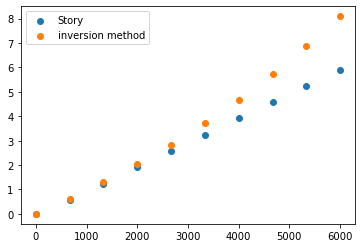

In [7]:
DM = np.linspace(0, 6000, 10)
plt.scatter(DM, get_z_story(DM), label='Story')
plt.scatter(DM, get_z(DM, "Zhang"), label='inversion method')
plt.legend()

In [11]:
c.DM(get_z(DM, "Zhang"), dDMdz=c.dDMdz_Zhang)+80 - DM

array([ 8.00000000e+01, -2.04998400e-06,  1.08882432e-08, -3.89484285e-08,
        4.30923046e-06, -8.59795364e-08, -1.91849949e-06,  7.35587491e-07,
       -2.88173396e-08, -1.13759597e-06])

# Luminosity Function

The general E_v function allows for any $\alpha$ and returns $\displaystyle L = \frac{4\pi D_L(z)^2}{(1+z)^{2-\alpha}} F$.
- Story's code uses $\alpha = 1$
- My original code uses $\alpha = 1.5$
- try a couple different values: $\alpha = 0.5, 1$

In [5]:
def get_L(fluence, rs, alpha=1):
    return c.E_v(fluence, rs, alpha=alpha)

# Differences in Kendall Tau Implementation

## Variables in Kendall Tau Calculation
- Story: $L$ and $L_{\mathrm{lim}}$
- Mine: $L$ vs $z$, with cutoff function

## Evolution Function
- Story evolves using the function 
$$g(z, \gamma) = x^\gamma \cdot \begin{cases} 
1 & x \leq x_{\mathrm{cr}}\\
\displaystyle \frac{1 + x_\mathrm{cr}^\gamma}{x^\gamma + x_\mathrm{cr}^\gamma} & x > x_\mathrm{cr}
\end{cases}$$
(not really dimensionally accurate)
- my evolves using two functions
    - $g(z, k) = $
- **use original g(z,k) equation with Z^k/(1+(Z/Z_Cr)^n)^(k/n)**

## Implementation of Evolution
- story: evolves only L
- mine: evolves both L and L_min

## Rank Calculation
- story: averages those with same $y$ value
- mine: $\leq$ is considered lower, $>$ considered higher


## TODO
- use dataset without ties
- break ties arbitrarily
- try different alpha values
- use original $g(z,k)$ function
- obtain working value of $k$, begin working from there
- can mention ASKAP and Parkes in paper, but CHIME clearly has more data. can see if those give similar results; if so, encouraging.

## More Stuff
- 
- (optional) re-run simulations for kendall tau, can be included as an appendix for how good the Efron-Petrosian method is
